***start*** ***point***

In [0]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
#from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
#from scipy.ndimage import imread

from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [0]:
!pip install imread

     |████████████████████████████████| 1.5MB 4.9MB/s 


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [0]:
train_dir = '/content/drive/My Drive/intel-image-classification/seg_train/seg_train'
test_dir = '/content/drive/My Drive/intel-image-classification/seg_test/seg_test'

In [68]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)  

train_gen = augs.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=8,
    class_mode = 'categorical'
)

test_gen = augs.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=8,
    class_mode='categorical'
)

Found 14039 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 150, 150, 3)       0         
_________________________________________________________________
block_1 (SeparableConv2D)    (None, 148, 148, 16)      91        
_________________________________________________________________
batch_normalization_13 (Batc (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
block_2 (SeparableConv2D)    (None, 72, 72, 32)        688       
_________________________________________________________________
batch_normalization_14 (Batc (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)       

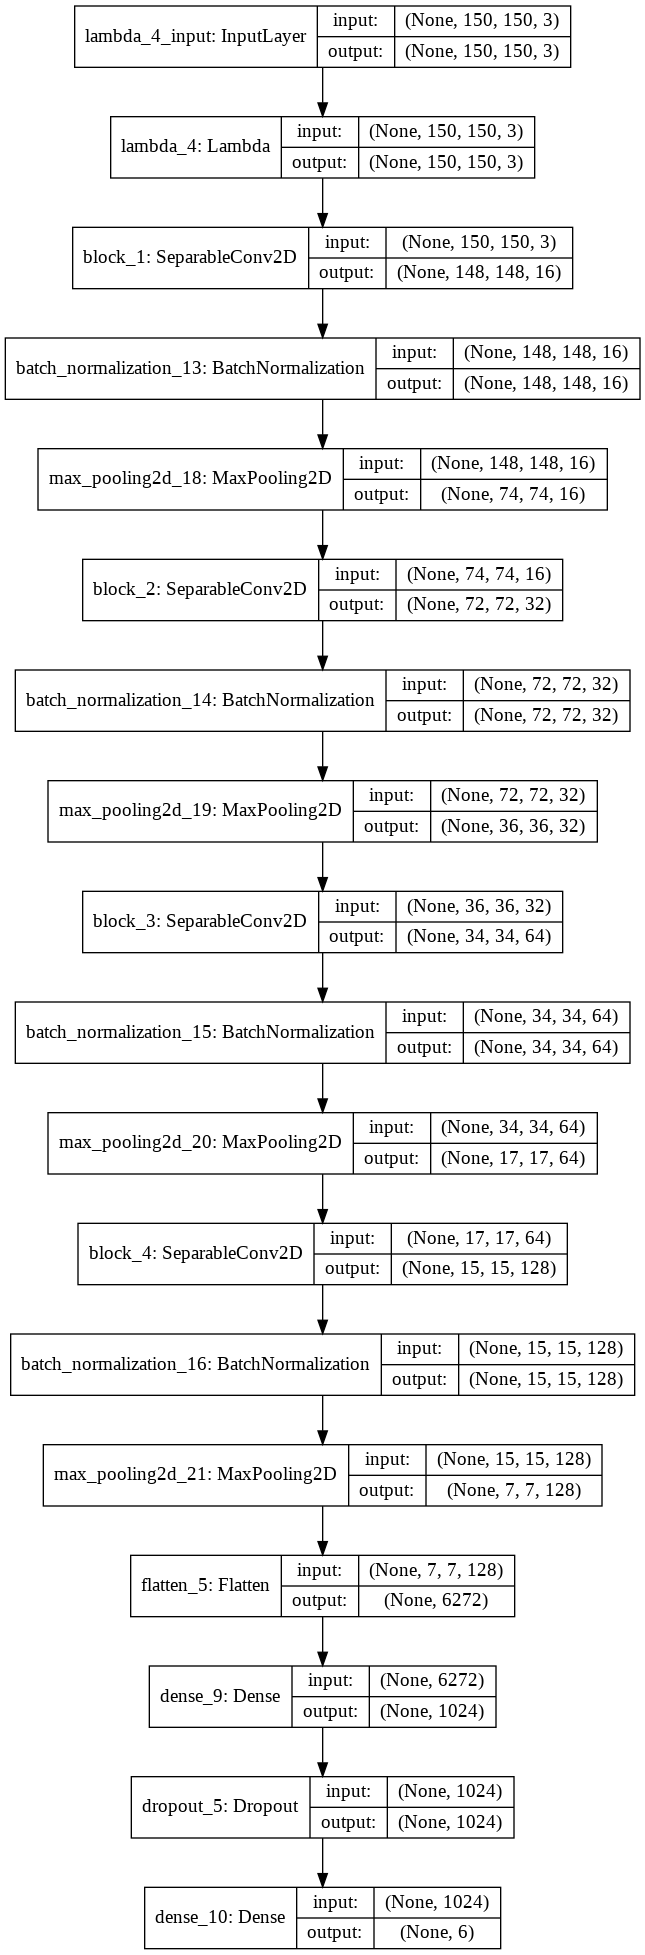

In [72]:
def ConvBlock(model, layers, filters,name):
    for i in range(layers):
        model.add(SeparableConv2D(filters, (3, 3), activation='relu',name=name))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(150, 150, 3)))
    ConvBlock(model, 1, 16,'block_1')
    ConvBlock(model, 1, 32,'block_2')
    ConvBlock(model, 1, 64,'block_3')
    ConvBlock(model, 1, 128,'block_4')
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6,activation='sigmoid'))
    return model

model = FCN()
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [0]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [74]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 500, 
    validation_data  = test_gen,
    validation_steps = 500,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
500/500 [==============================] - 1171s 2s/step - loss: 0.4717 - acc: 0.8201 - val_loss: 0.3650 - val_acc: 0.8561

Epoch 00001: val_loss improved from inf to 0.36496, saving model to ./base.model
Epoch 2/20
500/500 [==============================] - 1216s 2s/step - loss: 0.3224 - acc: 0.8684 - val_loss: 0.2633 - val_acc: 0.8900

Epoch 00002: val_loss improved from 0.36496 to 0.26330, saving model to ./base.model
Epoch 3/20
500/500 [==============================] - 1206s 2s/step - loss: 0.2848 - acc: 0.8814 - val_loss: 0.2736 - val_acc: 0.8836

Epoch 00003: val_loss did not improve from 0.26330
Epoch 4/20
500/500 [==============================] - 771s 2s/step - loss: 0.2655 - acc: 0.8877 - val_loss: 0.2361 - val_acc: 0.9022

Epoch 00004: val_loss improved from 0.26330 to 0.23611, saving model to ./base.model
Epoch 5/20
500/500 [==============================] - 246s 492ms/step - loss: 0.2538 - acc: 0.8943 - val_loss: 0.2324 - val_acc: 0.9018

Epoch 00005: val_loss 

Model Test Loss: 0.1691169340064128
Model Test Accuracy: 0.9331111084620158
Weights Saved


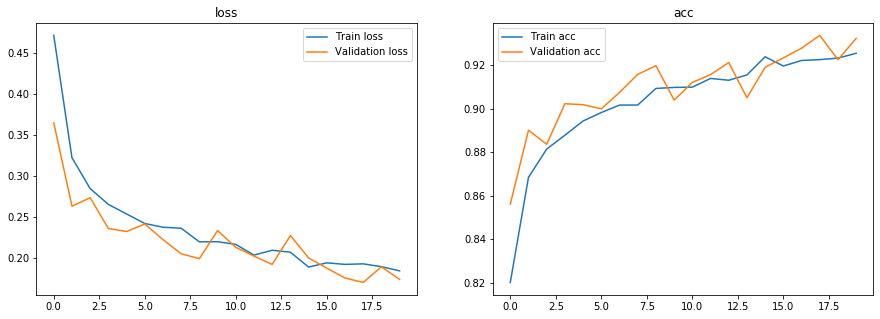

In [75]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(test_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")